# Fine tuning a classifier in scikit-learn

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

It’s easy to understand that many machine learning problems benefit from either precision or recall as their optimal performance metric but implementing the concept requires knowledge of a detailed process. My first few attempts to fine tune models for recall (sensitivity) were difficult, so I decided to share my experience.

This is my first Kaggle kernel, my aim wasn't to build the most robust classifier, I just wanted to show the practicality of optimizing for sensitivity.  In figure A below, I'd like to move the decision threshold to left to minimize the amount of false negatives, which would be especially important in cancer diagnoses.

<img src = 'https://c1.staticflickr.com/5/4340/37157583241_7cc603070c_z_d.jpg'>

Tuning a classifier for maximum sensitivity or specificity can be achieved in (at least) two main steps. The first is using `GridSearchCV` to fine tune your model and keep the classifier with the highest recall score. The second step is to adjust the decision threshold using the precision recall curve and the roc curve.

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

### Download data rom UCI Machine learning repository
- https://archive-beta.ics.uci.edu/ (Beta version)

pd.read_csv('./data/breast-cancer-wisconsin.txt', 
            names = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 
                      'compactness', 'concavity', 'conncave points', 'symmetry', 'fractal dimension']).head()

In [4]:
df = pd.read_csv('D:/2021_데이터솔루션/data/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
# class distribution
# diagnosis: B = 0, M = 1
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [6]:
# by default majority class (benign) will be negative
lb = LabelBinarizer()
df['diagnosis'] = lb.fit_transform(df['diagnosis'].values)
targets = df['diagnosis']

df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, inplace=True)

df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['targets'] = data.target  # 데이터 형식을 맞추기 위해
df = df[(df['targets'] == 0) | (df['targets'] == 1)]
targets = df['targets']

## feature selection

In [7]:
from sklearn.feature_selection import SelectFromModel
def random_forest(X, y):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(), 
                                          threshold='median')
    embeded_rf_selector.fit(df, targets)    
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    return embeded_rf_support, embeded_rf_feature

embeded_rf_support, embeded_rf_feature = random_forest(df, targets)

In [8]:
embeded_rf_support
'/'.join(embeded_rf_feature)

array([ True,  True,  True,  True, False, False,  True,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False, False])

'radius_mean/texture_mean/perimeter_mean/area_mean/concavity_mean/concave points_mean/area_se/radius_worst/texture_worst/perimeter_worst/area_worst/smoothness_worst/compactness_worst/concavity_worst/concave points_worst'

In [9]:
len(df.columns)
len(embeded_rf_feature)

30

15

RandomForestClassifier()

<Figure size 1800x432 with 0 Axes>

Text(0, 0.5, 'Features Importance')

([<matplotlib.axis.XTick at 0x2ad997b6dc0>,
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean'),
  Text(10, 0, 'radius_se'),
  Text(11, 0, 'texture_se'),
  Text(12, 0, 'perimeter_se'),
  Text(13, 0, 'area_se'),
  Text(14, 0, 'smoothness_se'),
  Text(15, 0, 'compactness_se'),
  Text(16, 0, 'concavity_se'),
  Text(17, 0, 'concave points_se'),
  Text(18, 0, 'symmetry_se'),
  Text(19, 0, 'fractal_dimension_se'),
  Text(20, 0, 'radius_worst'),
  Text(21, 0, 'texture_worst'),
  Text(22, 0, 'perimeter_worst'),
  Text(23, 0, 'area_worst'),
  Text(24, 0, 'smoothness_worst'),
  Text(25, 0, 'compactness_worst'),
  Text(26, 0, 'concavity_worst'),
  Text(27, 0, 'concave points_worst'),
  Text(28, 0, 'symmetry_worst'),
  Text(29, 0,

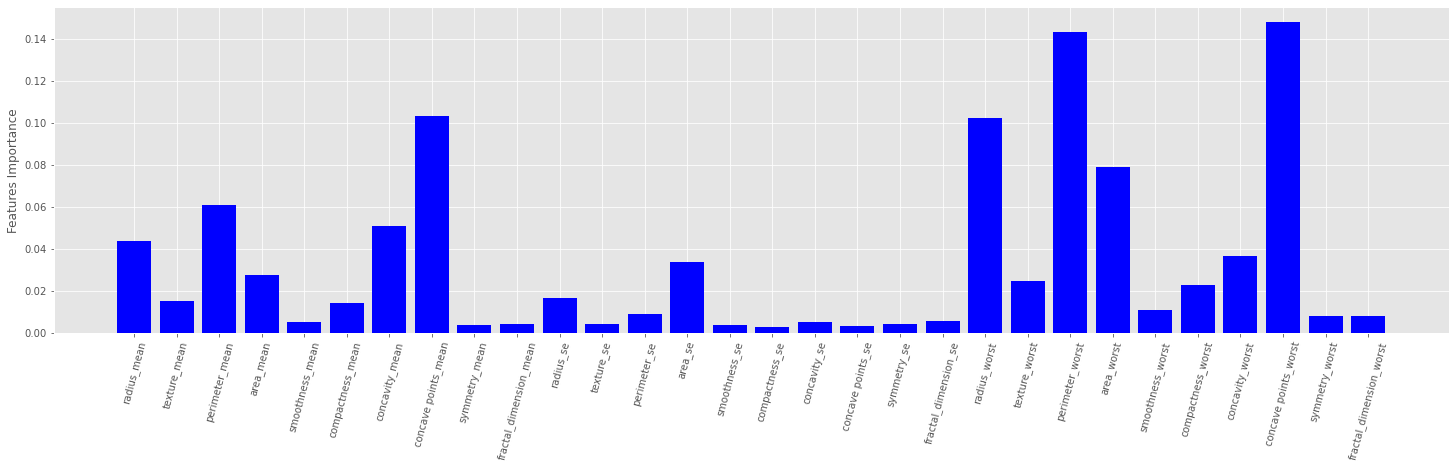

In [10]:
forest = RandomForestClassifier()
forest.fit(df, targets)
plt.figure(figsize=(25,6)); plt.ylabel('Features Importance')
ax = plt.bar(range(df.shape[1]), forest.feature_importances_, color='b')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation='75')

In [11]:
df = df[embeded_rf_feature]

### 훈련/검증데이터 fit

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, targets, stratify=targets)

`train_test_split` with `stratify=True` results in consistent class distribution betwen training and test sets.

In [13]:
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0    0.626761
1    0.373239
Name: diagnosis, dtype: float64
y_test class distribution
0    0.629371
1    0.370629
Name: diagnosis, dtype: float64


## First strategy: Optimize for sensitivity using GridSearchCV and scoring.

First build a generic classifier and setup a parameter grid; random forests have many tunable parameters, which make it suitable for `GridSearchCV`.

In [14]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

The `scorers` dictionary can be used as the `scoring` argument in `GridSearchCV`. When multiple scores are passed, `GridSearchCV.cv_results_` will return scoring metrics for each of the score types provided.

In [15]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

The function below uses  [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to fit several classifiers according to the combinations of parameters in the `param_grid`.  The scores from `scorers` are recorded and the best model (as scored by the `refit` argument) will be selected and "refit" to the full training data for downstream use.  This also makes predictions on the held out `X_test` and prints the confusion matrix to show performance.

The point of the wrapper function is to quickly reuse the code to fit the best classifier according to the type of scoring metric chosen. First, try `precision_score`, which should limit the number of false positives. This isn't well-suited for the goal of maxium sensitivity, but allows us to quickly show the difference between a classifier optimized for `precision_score` and one optimized for `recall_score`.

In [46]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=3)
    
    grid_search = GridSearchCV(clf, 
                               param_grid, scoring=scorers, 
                               refit = refit_score,
                               cv = skf, 
                               return_train_score=True, n_jobs=-1)
    
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    return grid_search

In [47]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 15, 'max_features': 3, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        86         4
pos         3        50


The precision, recall, and accuracy scores for every combination of the parameters in `param_grid` are stored in `cv_results_`.  Here, a pandas DataFrame helps visualize the scores  and parameters for each classifier iteration. This is included to show that although accuracy may be relatively consistent across classifiers, it's obvious that precision and recall have a trade-off. Sorting by precision, the best scoring model should be the first record. This can be checked by looking at the parameters of the first record and comparing them to `grid_search.best_params_` above.

In [48]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
50,0.954804,0.924528,0.955399,15,3,5,100
3,0.953964,0.905660,0.948357,3,3,5,300
76,0.950203,0.943396,0.960094,25,3,10,100
27,0.949579,0.943396,0.960094,5,3,5,300
25,0.949307,0.937107,0.957746,5,3,3,300


That classifier was optimized for precision. For comparison, to show how `GridSearchCV` selects the best classifier, the function call below returns a classifier optimized for recall. The grid might be similar to the grid above, the only difference is that the classifer with the highest recall will be refit. This will be the most desirable metric in the cancer diagnosis classification problem, there should be less false negatives on the test set confusion matrix.

In [49]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 5, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg        85         5
pos         2        51


In [50]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
62,0.939304,0.943396,0.955399,15,10,5,100
31,0.944044,0.943396,0.957746,5,5,3,300
83,0.944044,0.943396,0.957746,25,5,10,300
58,0.932531,0.943396,0.953052,15,5,10,100
37,0.945231,0.943396,0.957746,5,10,3,300


The first strategy doesn't yield impressive results for `recall_score`, it doesn't significantly reduce (if at all) the number of false negatives compared to the classifier optimized for `precision_score`. Ideally, when designing a cancer diagnosis test, the classifier should strive for the fewest false negatives as possible.

## Strategy 2: Adjust the decision threshold -- Identify the operating point

The `precisoin_recall_curve` and `roc curve` are useful tools to visualize the sensitivity-specificty tradeoff in the classifier. They can help inform a data scientist where to set the decision threshold of the model to maximize either sensitivity or specificity. This is called the "operating point" of the model.

An important point to make this method generalizable to all classifiers in scikit-learn is to understand that some classifiers (like RandomForest) use `.predict_proba()` while others (like SVC) use `.decision_function()`. The idea is to get the "probability" that a sample is predicted to be in a class, not just the class returned from `.predict()`. The default threshold for `RandomForestClassifier` is 0.5

In [51]:
# this gives the probability [0,1] that each sample belongs to class 1
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]

# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

In [52]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [53]:
# generate the precision recall curve
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [54]:
def precision_recall_threshold(t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

Re-execute this cell to tune the threshold until there are 0 False Negatives. On this particular run, I had to go all the way down to 0.0 before reducing the false negatives to 0. Unfortunately this means I predicted everything positive!


     pred_neg  pred_pos
neg        77        13
pos         0        53


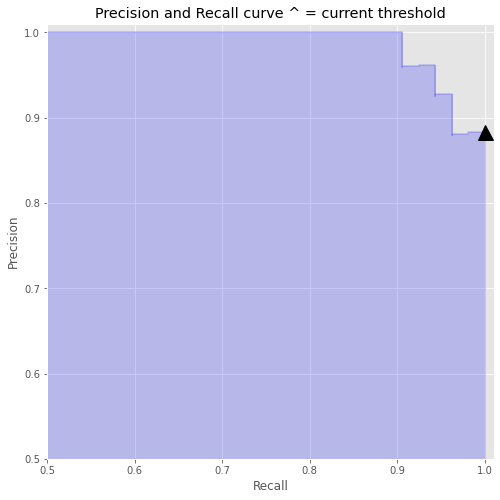

In [55]:
# The best I could do with 1 FN was 0.17, but re-execute to watch the confusion matrix change.
precision_recall_threshold(0.17)

Another way to view the tradeoff between precision and recall is to plot them together as a function of the decision threshold.

In [56]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

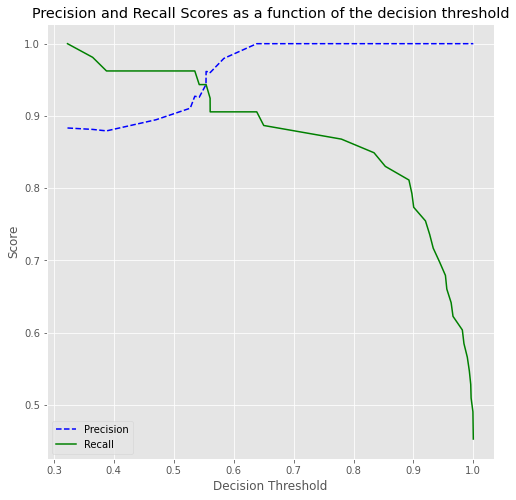

In [57]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

Finally, the ROC curve shows that to achieve a 1.0 recall, we must accept some false positive rate > 0.0.

In [58]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9953878406708595


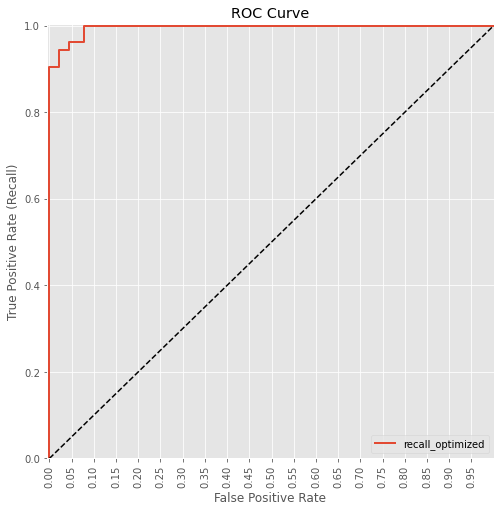

In [59]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

Thanks for following along. I'm interested to hear suggestions to improve the code and/or the classifiers.

# End